In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import math
from math import factorial
from scipy import stats as st
import os

# Сделать предварительный анализ тарифов на небольшой выборке клиентов.

Изучить показатели тарифов, использование их возможностей клиентами и сделать выводы о перспективе.

# Шаг 1. Откройте файл с данными и изучите общую информацию

In [2]:
data_calls = pd.read_csv('/datasets/calls.csv')
data_calls.head(5)

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [3]:
data_internet = pd.read_csv('/datasets/internet.csv')
data_internet.head(5)

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [4]:
data_messages = pd.read_csv('/datasets/messages.csv')
data_messages.head(5)

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [5]:
data_tariffs = pd.read_csv('/datasets/tariffs.csv')
data_tariffs.head(5)

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [6]:
data_users = pd.read_csv('/datasets/users.csv')
data_users.head(5)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [7]:
for file in os.listdir('/datasets/'):
    name = file.split('.csv')[0]
    if name in ['calls', 'internet', 'messages', 'tariffs', 'users']:
        data = pd.read_csv('/datasets/{}'.format(file))
        print(name)
        print(data.info())
        print(data.describe(include='all'), '\n')
        for columns in data.columns:
            print(columns)
            print(data[columns].unique(), '\n')
            print(data[columns].value_counts(), '\n')
        print('file_end', '\n')

calls
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
None
            id   call_date       duration        user_id
count   202607      202607  202607.000000  202607.000000
unique  202607         365            NaN            NaN
top     1406_7  2018-12-31            NaN            NaN
freq         1        1435            NaN            NaN
mean       NaN         NaN       6.755887    1253.940619
std        NaN         NaN       5.843365     144.722751
min        NaN         NaN       0.000000    1000.000000
25%        NaN         NaN       1.300000    1126.000000
50%        NaN         NaN       6.000000    1260.000000
75%        NaN         NaN      10.700000    1379.000000
max        NaN         NaN      38.000000    1

In [8]:
data_calls.info()
data_internet.info()
data_messages.info()
data_tariffs.info()
data_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB
<class 'pandas.core.frame.DataFrame'>
Rang

На данный момент есть несколько файлов с разной информацией. Для простоты анализа, необходимо объеденить эти данные в один общий дф.
Есть подозрительные колонуки и колонки, которые не будут задействованны в анализе.
Имеются 0.0 в столбце duration в кол-ве 39613. Считаю это неответом на звонок и необходимым заменить нули на Нан, дабы не учитывать такие данные как состоявшиеся звонки.
Сменить тип данных, где это необходимо.

# Шаг 2. Подготовьте данные

In [9]:
data_calls['month'] = pd.DatetimeIndex(pd.to_datetime(data_calls['call_date'], format='%Y-%m-%d')).month
data_internet['month'] = pd.DatetimeIndex(pd.to_datetime(data_internet['session_date'], format='%Y-%m-%d')).month
data_messages['month'] = pd.DatetimeIndex(pd.to_datetime(data_messages['message_date'], format='%Y-%m-%d')).month
data_users['churn_date'] = pd.to_datetime(data_users['churn_date'], format='%Y-%m-%d')
data_users['reg_date'] = pd.to_datetime(data_users['reg_date'], format='%Y-%m-%d')

In [10]:
# Замена типа у дат и простановка месяцев в отдельный столбец для последующей группировки

In [11]:
data_users['user_id'] = data_users['user_id'].astype('object')

In [12]:
# Замена типа id на object

In [13]:
data_internet = data_internet.drop('Unnamed: 0', axis = 1)

In [14]:
# Убираем столбец

In [15]:
data_calls['duration'] = np.ceil(data_calls['duration']).astype('int')

In [16]:
# Округляем данные по duration в большую сторону

In [17]:
data_calls['duration'] = data_calls['duration'].replace(0, np.nan)

In [18]:
# Замена 0.0 на НаН

In [19]:
data_internet['mb_used'] = np.ceil(data_internet['mb_used']).astype('int')

In [20]:
# Округляем данные по mb_used в большую сторону

In [21]:
table_calls = data_calls.pivot_table(index=['user_id', 'month'], values='duration',  aggfunc=['sum', 'count'])
table_calls.columns = ['duration', 'calls_in_month']
table_calls['duration'] = table_calls['duration'].astype('int')
table_calls

duration  calls_in_month
user_id month                          
1000    5           159              17
        6           172              28
        7           340              41
        8           408              42
        9           466              46
...                 ...             ...
1498    10          247              30
1499    9            70               8
        10          449              44
        11          612              62
        12          492              56

[3174 rows x 2 columns]

In [22]:
# Начинаем объединять множество ДФ в один, группируя по пользователям и месяцам

In [23]:
table_internet = data_internet.pivot_table(index=['user_id', 'month'], values='mb_used', 
                                           aggfunc='sum')
table_internet

mb_used
user_id month         
1000    5         2256
        6        23257
        7        14016
        8        14070
        9        14581
...                ...
1498    10       20604
1499    9         1848
        10       17809
        11       17984
        12       13077

[3203 rows x 1 columns]

In [24]:
table_messages = data_messages.pivot_table(index=['user_id', 'month'], values='id', aggfunc='count')
table_messages.columns = ['messages_in_month']
table_messages

messages_in_month
user_id month                   
1000    5                     22
        6                     60
        7                     75
        8                     81
        9                     57
...                          ...
1498    10                    42
1499    9                     11
        10                    48
        11                    59
        12                    66

[2717 rows x 1 columns]

In [25]:
All_tables = table_messages.join([table_internet, table_calls], how='outer')

In [26]:
data_users = data_users.drop_duplicates().reset_index(drop=True)

In [27]:
data_users

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
...,...,...,...,...,...,...,...,...
495,1495,65,NaT,Иркутск,Авксентий,Фокин,2018-08-28,ultra
496,1496,36,NaT,Вологда,Трифон,Блохин,2018-01-27,smart
497,1497,32,NaT,Челябинск,Каролина,Агеева,2018-10-09,smart
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart


In [28]:
users_tariff_tables = data_users.merge(data_tariffs, left_on='tariff', right_on='tariff_name', how='outer')
users_tariff_tables

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,ultra
1,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra,1000,30720,3000,1950,150,1,1,ultra
2,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra,1000,30720,3000,1950,150,1,1,ultra
3,1013,36,NaT,Иваново,Борис,Андреенко,2018-11-14,ultra,1000,30720,3000,1950,150,1,1,ultra
4,1016,58,NaT,Омск,Марица,Сазонова,2018-11-21,ultra,1000,30720,3000,1950,150,1,1,ultra
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1494,62,NaT,Омск,Ренат,Андропов,2018-08-17,smart,50,15360,500,550,200,3,3,smart
496,1496,36,NaT,Вологда,Трифон,Блохин,2018-01-27,smart,50,15360,500,550,200,3,3,smart
497,1497,32,NaT,Челябинск,Каролина,Агеева,2018-10-09,smart,50,15360,500,550,200,3,3,smart
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart,50,15360,500,550,200,3,3,smart


In [29]:
users_tables = All_tables.join(users_tariff_tables[['user_id', 'city', 'tariff', 'messages_included','mb_per_month_included', \
                                           'minutes_included', 'rub_monthly_fee', 'rub_per_gb', 'rub_per_message', \
                                           'rub_per_minute']].set_index('user_id'), on='user_id')

In [30]:
# Оставляем только необходимые нам столбцы

In [31]:
users_tables

messages_in_month  mb_used  duration  calls_in_month  \
user_id month                                                         
1000    5                   22.0   2256.0     159.0            17.0   
        6                   60.0  23257.0     172.0            28.0   
        7                   75.0  14016.0     340.0            41.0   
        8                   81.0  14070.0     408.0            42.0   
        9                   57.0  14581.0     466.0            46.0   
...                          ...      ...       ...             ...   
1498    10                  42.0  20604.0     247.0            30.0   
1499    9                   11.0   1848.0      70.0             8.0   
        10                  48.0  17809.0     449.0            44.0   
        11                  59.0  17984.0     612.0            62.0   
        12                  66.0  13077.0     492.0            56.0   

                      city tariff  messages_included  mb_per_month_included  \
user_id month                                                                 
1000    5        Краснодар  ultra               1000                  30720   
        6        Краснодар  ultra               1000                  30720   
        7        Краснодар  ultra               1000                  30720   
        8        Краснодар  ultra               1000                  30720   
        9        Краснодар  ultra               1000                  30720   
...                    ...    ...                ...                    ...   
1498    10     Владикавказ  smart                 50                  15360   
1499    9            Пермь  smart                 50                  15360   
        10           Пермь  smart                 50                  15360   
        11           Пермь  smart                 50                  15360   
        12           Пермь  smart                 50                  15360   

               minutes_included  rub_monthly_fee  rub_per_gb  rub_per_message  \
user_id month                                                                   
1000    5                  3000             1950         150                1   
        6                  3000             1950         150                1   
        7                  3000             1950         150                1   
        8                  3000             1950         150                1   
        9                  3000             1950         150                1   
...                         ...              ...         ...              ...   
1498    10                  500              550         200                3   
1499    9                   500              550         200                3   
        10                  500              550         200                3   
        11                  500              550         200                3   
        12                  500              550         200                3   

               rub_per_minute  
user_id month                  
1000    5                   1  
        6                   1  
        7                   1  
        8                   1  
        9                   1  
...                       ...  
1498    10                  3  
1499    9                   3  
        10                  3  
        11                  3  
        12                  3  

[3214 rows x 13 columns]

In [32]:
def pay_month(data1):
    pay = 0
    message = 0
    internet = 0
    calls = 0
    if data1['messages_in_month'] > data1['messages_included']:
        message = (data1['messages_in_month'] - data1['messages_included']) * data1['rub_per_message']
        #print(message)
    if data1['mb_used'] > data1['mb_per_month_included']:
        internet = np.ceil((data1['mb_used'] - data1['mb_per_month_included'])/1024) * data1['rub_per_gb']
    if data1['duration'] > data1['minutes_included']:
        calls = (data1['duration'] - data1['minutes_included']) * data1['rub_per_minute']
    pay = message + internet + calls + data1['rub_monthly_fee']
    return pay

In [33]:
# функция по созданию столбца с помесячной платой пользователей

In [34]:
users_tables['pay'] = users_tables.apply(pay_month, axis = 1)
good_table = users_tables[['messages_in_month', 'mb_used', 'duration', 'calls_in_month', 'city', 'tariff', 'pay']]
good_table

messages_in_month  mb_used  duration  calls_in_month  \
user_id month                                                         
1000    5                   22.0   2256.0     159.0            17.0   
        6                   60.0  23257.0     172.0            28.0   
        7                   75.0  14016.0     340.0            41.0   
        8                   81.0  14070.0     408.0            42.0   
        9                   57.0  14581.0     466.0            46.0   
...                          ...      ...       ...             ...   
1498    10                  42.0  20604.0     247.0            30.0   
1499    9                   11.0   1848.0      70.0             8.0   
        10                  48.0  17809.0     449.0            44.0   
        11                  59.0  17984.0     612.0            62.0   
        12                  66.0  13077.0     492.0            56.0   

                      city tariff     pay  
user_id month                              
1000    5        Краснодар  ultra  1950.0  
        6        Краснодар  ultra  1950.0  
        7        Краснодар  ultra  1950.0  
        8        Краснодар  ultra  1950.0  
        9        Краснодар  ultra  1950.0  
...                    ...    ...     ...  
1498    10     Владикавказ  smart  1750.0  
1499    9            Пермь  smart   550.0  
        10           Пермь  smart  1150.0  
        11           Пермь  smart  1513.0  
        12           Пермь  smart   598.0  

[3214 rows x 7 columns]

In [35]:
# добавляем столбец 'pay' при помощи написанной функции

В этот раз данные чище, нежели чем в прошлые разы. В данный момент мы имеем один полный ДФ со столбцом помесячной оплаты.
Расчет данного столбца был произведен исходя из условий, которые были прописанны в тз: 
- округление .0 вверх
- стоимость звонков, сообщений и интернета в зависимости от тарифа.
- разбивка по месяцам и пользователям

# Шаг 3. Проанализируйте данные

In [36]:
data_users.groupby('tariff').count()

,user_id,age,churn_date,city,first_name,last_name,reg_date
tariff,,,,,,,
smart,351,351,23,351,351,351,351
ultra,149,149,15,149,149,149,149


In [37]:
# группа по тарифу

In [38]:
arr = ['messages_in_month', 'mb_used', 'duration', 'calls_in_month']

In [39]:
# создаем список для функций

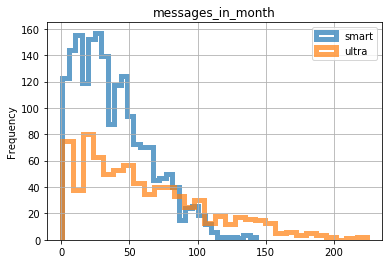

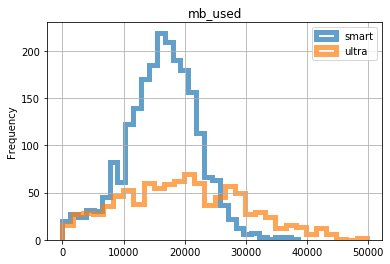

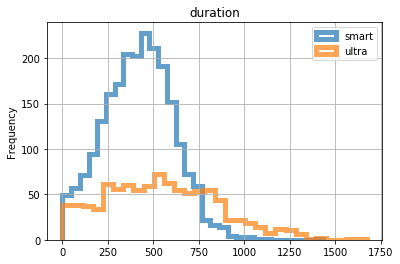

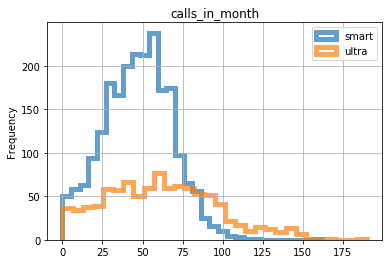

In [40]:
def hist_tariff(data, list):
    i = 0
    while i <= len(list) - 1:
        name = list[i]
#         data.query('tariff == "smart"').plot(kind='hist', y=name, bins=30, grid=True, title='smart '+name)
#         data.query('tariff == "ultra"').plot(kind='hist', y=name, bins=30, grid=True, title='ultra '+name)
        ax = data.query('tariff == "smart"').plot(kind='hist', y=name, bins=30, grid=True, title=name, alpha = 0.7,
                                             linewidth=5, histtype='step', label='smart')
        data.query('tariff == "ultra"').plot(kind='hist', y=name, bins=30, grid=True, title=name, 
                                             alpha = 0.7, linewidth=5, histtype='step', label='ultra', ax = ax)
        i += 1
hist_tariff(good_table, arr)

In [41]:
# сравнение двух тарифов по звонкам, минутам, сообщениям и использованию интернета
# Видим, что распределение у тарифа ультра намного шире, нежели чем у смарта. 
# Но основное количество людей от двух тарифов находятся рядом

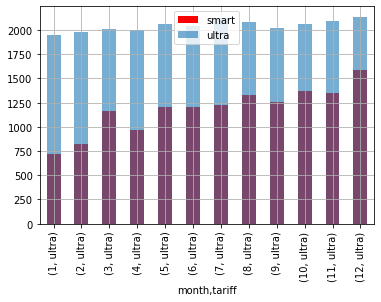

In [42]:
good_bar = good_table.pivot_table(index=['month', 'tariff'], values='pay', aggfunc='mean')
ab = good_bar.query('tariff == "smart"').plot(kind='bar', y='pay', grid=True, color='red', label='smart')
good_bar.query('tariff == "ultra"').plot(kind='bar', y='pay', grid=True, ax=ab, alpha = .6, label='ultra')

In [43]:
# сравнение средних показателей по оплате в месяц для каждого тарифа.

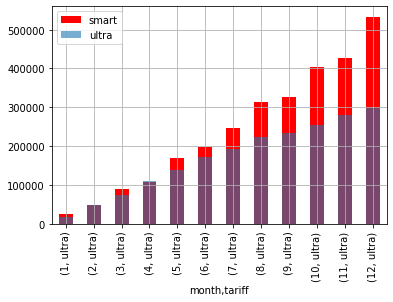

In [44]:
good_bar = good_table.pivot_table(index=['month', 'tariff'], values='pay', aggfunc='sum')
ab = good_bar.query('tariff == "smart"').plot(kind='bar', y='pay', grid=True, color='red', label='smart')
good_bar.query('tariff == "ultra"').plot(kind='bar', y='pay', grid=True, ax=ab, alpha = .6, label='ultra')

In [45]:
# сравнение общей суммы, полученной с каждого тарифа в месяц(основываясь на имеющихся данных)

In [46]:
def describe_tariff(data, list):
    i = 0
    while i <= len(list) - 1:
        name = list[i]
        print('SMART')
        print(name)
        print(np.mean(data[name][data['tariff'] == 'smart']))
        print(np.var(data[name][data['tariff'] == 'smart'], ddof=1))
        print(np.std(data[name][data['tariff'] == 'smart'], ddof=1))
        print()
        print('ULTRA')
        print(name)
        print(np.mean(data[name][data['tariff'] == 'ultra']))
        print(np.var(data[name][data['tariff'] == 'ultra'], ddof=1))
        print(np.std(data[name][data['tariff'] == 'ultra'], ddof=1))
        print()
        i += 1
describe_tariff(good_table, arr)

SMART
messages_in_month
38.71644120707596
717.5942011753547
26.787948804926344

ULTRA
messages_in_month
61.161006289308176
2109.6591828651995
45.93102636416042

SMART
mb_used
16236.47262118492
34443100.68133359
5868.824471845583

ULTRA
mb_used
19686.76717948718
99043439.60795662
9952.057054094726

SMART
duration
419.0629779577148
35844.1895513438
189.3256177894154

ULTRA
duration
545.4511041009464
94203.41839614809
306.9257538821858

SMART
calls_in_month
47.07422402159244
437.8743262990266
20.925446860199344

ULTRA
calls_in_month
61.354363827549946
1179.8963993580164
34.34962007589045



In [47]:
data_tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [48]:
# у тарифа смарт наблюдается превышение среднего значения в нескольких показателях.
# с другой стороны, многие не полностью пользуются возможностями тарифа ультра.

Из наблюдений, которые были проведены, очевидно, что лучше всего для "Мегалайн" подключать клиентам тариф Ультра.
Но тариф смарт приности больше прибыли из-за того, что:
- он массовый
- клиенты постоянно переходят через свой леммит
Последний месяц показал разницу выручки в 1.5 раза в пользу тарифа "смарт"

На месте компании я бы подумал над хорошей рекламной компании тарифа ультра, или сделал бы цену чуть меньше, немного урезав потолок возможностей для клиентов.

# Шаг 4. Проверьте гипотезы

Почти любое распределение согласно ЦПТ можно апроксимировать к нормальному и соответственно применять критерии для нормальных распределений, например t-тест. В данном случае наш датасет имеет большое кол-во наблюдений и сторогими процедурами можно пренебречь, поэтому сразу применим t-критерий Стьюдента.

In [49]:
# Нулевая гипотеза - средняя выручка пользователей тарифов «Ультра» и «Смарт» не различается
# Альтернативная гипотеза - средняя выручка пользователей тарифов «Ультра» и «Смарт» различается
alpha = .05
smart_income = good_table['pay'][good_table['tariff'] == 'smart']
ultra_income = good_table['pay'][good_table['tariff'] == 'ultra']
results_1 = st.ttest_ind(smart_income, ultra_income)
print('p-значение: ', results_1.pvalue)
if (results_1.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  2.9776448000521676e-158
Отвергаем нулевую гипотезу


Для выбранного уровня значимости происходит отвержение нулевой теории. Делаем вывод, что средняя выручка тарифов отличается, т.к. нулевая гипотеза для двухстороннего ttest всегда говорит о равенсте средних.

In [51]:
# Функция нужна для выбора теста на проверку равенства двух средних в зависимости от распределения
def equal_mean_test(sample_1: 'Series', sample_2: 'Series'):
# принимает в качестве аргумента 2 Series,
# проверяет нормальность распределения тестом Шапиро;
   
# если нулевая гипотеза о нормальности распределения отвергается,
# равенство средних проверяется тестом Манна-Уитни;
   
# если нулевая гипотеза о нормальности распределения не отвергается,
# равенство средних проверяется t-тестом Стьюдента;
   
# в результате выводит на экран p-значение выбранного теста и результат сравнения с заданным уровнем значимости

   
    # тест Шапиро на соответствие распределения нормальному
    shapiro_stat_1, shapiro_p_1 = st.shapiro(sample_1)
    shapiro_stat_2, shapiro_p_2 = st.shapiro(sample_2)
    alpha = .05
    print(shapiro_p_1)
    print(shapiro_p_2)
   
    # гипотеза о нормальности распределения отвергается
    if shapiro_p_1 < alpha and shapiro_p_2 < alpha:
        u_alpha = .01
        u_results = st.mannwhitneyu(sample_1, sample_2, alternative='two-sided')
        print('Нулевая гипотеза о нормальности распределения отвергается')
        print('Равенство средних проверяется тестом Манна-Уитни')
        print('p-значение: {:.10f}'.format(u_results.pvalue))
        if u_results.pvalue < u_alpha:
            print("Отвергаем нулевую гипотезу")
        else:
            print("Не получилось отвергнуть нулевую гипотезу")
   
    # гипотеза о нормальности распределения не отвергается
    if shapiro_p_1 >= alpha and shapiro_p_2 >= alpha:
        t_alpha = .01
        equal_var = equal_var_test(sample_1, sample_2) # функция использует тест Левена
        t_results = st.ttest_ind(sample_1, sample_2, equal_var=equal_var)
        print('Нулевая гипотеза о нормальности распределения не отвергается')
        print('Равенство средних проверяется t-тестом Стьюдента')
        print('var-значение серии 1', np.var(sample_1))
        print('var-значение серии 2', np.var(sample_2))
        print('p-значение: {:.10f}'.format(t_results.pvalue))
        if t_results.pvalue < t_alpha:
            print("Отвергаем нулевую гипотезу")
        else:
            print("Не получилось отвергнуть нулевую гипотезу")

In [53]:
# Нулевая гипотеза - средняя выручка пользователей тарифов «Ультра» и «Смарт» не различается
# Альтернативная гипотеза - средняя выручка пользователей тарифов «Ультра» и «Смарт» различается
equal_mean_test((good_table['pay'][good_table['tariff'] == 'smart']), (good_table['pay'][good_table['tariff'] == 'ultra']))

2.022073684020711e-42
0.0
Нулевая гипотеза о нормальности распределения отвергается
Равенство средних проверяется тестом Манна-Уитни
p-значение: 0.0000000000
Отвергаем нулевую гипотезу


In [50]:
# Гипотеза - средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов
moscow_income = good_table['pay'][good_table['city'] == 'Москва']
no_moscow_income = good_table['pay'][good_table['city'] != 'Москва']
results_2 = st.ttest_ind(moscow_income, no_moscow_income)
print('p-значение: ', results_2.pvalue)
if (results_2.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.531666503831252
Не получилось отвергнуть нулевую гипотезу


In [54]:
# Нулевая гипотеза - средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов
# Альтернативная гипотеза - средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов
equal_mean_test((good_table['pay'][good_table['city'] == 'Москва']), (good_table['pay'][good_table['city'] != 'Москва']))

1.9057193120289288e-19
6.684653300725676e-39
Нулевая гипотеза о нормальности распределения отвергается
Равенство средних проверяется тестом Манна-Уитни
p-значение: 0.3841753554
Не получилось отвергнуть нулевую гипотезу


Для выбранного уровня значимости не происходит отвержение нулевой теории. Делаем вывод, что средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов, т.к. нулевая гипотеза для двухстороннего ttest всегда говорит о равенсте средних.

Выбираем небольшую значимость, т.к. у нас достаточно конкретная цель - узнать, есть ли разница.
Выводим две нулевые и две альтернативные гипотезы.
Одна гипотеза подтвердилась, другая - нет.

# Шаг 5. Напишите общий вывод

Исходя из среднего по тарифам, лучше всего работает тариф ультра. Но если мы посмотрим общие цифры дохода, то видим картину, в которой тариф смарт доминирует.
Это и следовало олжидать, так как он массовый - в 2.3 раза больше людей, нежели чем в ультра.
Подорожание тарифа смарт или удешевение тарифа ультра могут исправить ситуацию:
- например уменьшить лиммит, тк множество пользователей не могут его достигнуть, и через снижение цены на тариф, перевести с тарифа смарт на тариф ультра.
Очевидно, что лучше всего для компании будет пересадить всех пользователей на тариф подороже.

Так же выдвигались теории, итогом которых было выявленно:
- средняя выручка пользователей тарифов «Ультра» и «Смарт» различается. Это ожидаемый факт, так как средний пользователь смарта хоть и пересекает лиммит, но не настолько, чтобы догнать по стоимости ультру.
- средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов. Что удивительно, ведь казалось бы, что пересекать леммит и подключить тариф ультру в москве могут позволить больше людей.